In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import LeakyReLU, ReLU, Activation, Multiply, GaussianNoise, SeparableConv2D
from tensorflow.keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector, LayerNormalization, Add
from IPython.display import clear_output
import numpy as np
import cv2 as cv

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import pathlib
from IPython import display

In [4]:
# Your CPU supports instructions that this TensorFlow binary was not compiled to use\
# # Just disables the warning, doesn't enable AVX/FMA
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [84]:
generator = tf.keras.models.load_model('../generator_saves/generator--89-53.9974.h5')

W0903 19:25:39.383854 140049953625920 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [34]:
def otsu_canny(image, lowrate=0.1):
    if len(image.shape) > 2:
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Otsu's thresholding
    ret, _ = cv.threshold(image, thresh=0, maxval=255, type=(cv.THRESH_BINARY + cv.THRESH_OTSU))
    edged = cv.Canny(image, threshold1=(ret * lowrate), threshold2=ret)

    # return the edged image
    return edged

In [66]:
def create_mask(x= 224 // 2 - 224 // 8 , y= 224 // 2 - 224 // 8):
#     mask_width, mask_height = np.random.randint(image_size // 8, image_size // 3, size = 2)
    mask_width, mask_height = image_size // 4, image_size // 4
    mask = np.ones((image_size, image_size), dtype = np.uint8)
    mask_x = x if x is not None else np.random.randint(0, image_size - mask_width)
    mask_y = y if y is not None else np.random.randint(0, image_size - mask_height)
    mask[mask_y:mask_y + mask_height, mask_x:mask_x + mask_width] = 0
    return mask, mask_x, mask_y, mask_height, mask_width

In [67]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    
    return x

In [68]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)

    return x

In [69]:
def read_labels(path, sigma = 0.33):
#Add mask to train

    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    
    temp = np.array(image)
    temp = cv.resize(temp, (image_size, image_size), interpolation = cv.INTER_AREA)
    image = tf.cast(tf.convert_to_tensor(temp), tf.float32)
    
    mask, mask_x, mask_y, mask_height, mask_width = create_mask()
    
#     mask = np.ones((image_size, image_size), dtype = np.uint8)
#     cv.rectangle(mask, (image_size // 2 - image_size // 8, image_size // 2 - image_size // 8) , (image_size // 2 + image_size // 8, image_size // 2 + image_size // 8), 0, -1)
    
#     v = np.median(temp)
#     lower = min(0, v * (1 - sigma))
#     upper = max(255, v * (1 + sigma))
    

#     edge_map = tf.expand_dims(tf.convert_to_tensor(cv.Canny(temp, lower, upper)), axis = 2)
    mask_image = tf.cast(tf.expand_dims(tf.convert_to_tensor(mask), axis = 2), tf.float32)

    temp[mask_y : mask_y + mask_height, mask_x : mask_x + mask_width] = np.random.normal(127.5, scale = 5, size = (mask_height, mask_width, 3))
    edge_map = tf.cast(tf.expand_dims(tf.convert_to_tensor(otsu_canny(temp)), axis = 2), tf.float32)
    train_image = tf.cast(tf.convert_to_tensor(temp), tf.float32)
    
    
    train_image -= 127.5
    train_image /= 127.5
    edge_map -= 127.5
    edge_map /= 127.5
   
    
    image_edge_mask = tf.concat([train_image, edge_map, mask_image], axis = 2)
    
    image -= 127.5
    image /= 127.5

    return tf.concat([image_edge_mask, image], axis = 2)

In [70]:
def preprocess_image(path):
    image = tf.py_function(read_labels, [path], tf.float32)
    return (image[:,:, :5], image[:, :, 5:])

In [71]:
folders = [x[0] for x in os.walk(pathlib.Path('./arcDataset'))][1:]

In [72]:
all_image_paths = []
for folder in folders:
    data_root = pathlib.Path(folder)
    appendix = list(data_root.glob('*'))
    appendix = [str(path) for path in appendix]
    for elem in appendix:
        all_image_paths.append(elem)
image_count = len(all_image_paths)
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
all_image_paths.sort()

In [4]:
# Hyperparameters
image_size = 224 
latent_dim = 100
lr_d = 0.0001
lr_g = 0.0001
loss_d = 1.0
loss_g = 1.0
batch_size = 16
beta1 = 0.5
weight_init_stdev = 0.02
eps = 0.00005
samples_to_show = 5
EPOCHS = 100
num_examples_to_generate = 16

buffer_size = 10

In [74]:
image_ds = path_ds.map(preprocess_image)
ds = image_ds.shuffle(buffer_size).batch(batch_size).prefetch(-1)

In [5]:
def decode_block(im_in, filter_size):
    conv1 = Conv2D(filter_size, 3, padding = 'same', kernel_initializer = 'he_normal')(im_in)
    relu11 = LeakyReLU(0.2)(conv1)
    conv2 = Conv2D(filter_size, 3, padding = 'same', kernel_initializer = 'he_normal')(relu11)
    sum1 = Add()([conv2, conv1])
    relu12 = LeakyReLU(0.2)(sum1)
    down1 = Conv2D(filter_size * 2, 3, strides = 2,  padding = 'same', kernel_initializer = 'he_normal')(relu12)
    relu13 = LeakyReLU(0.2)(down1)
    
    return relu13, relu12

In [6]:
def encode_block(im_in, res_in, filter_size):
    conv1 = Conv2D(filter_size, 3, padding = 'same', kernel_initializer = 'he_normal')(im_in)
    relu11 = LeakyReLU(0.2)(conv1)
    conv2 = Conv2D(filter_size, 3, padding = 'same', kernel_initializer = 'he_normal')(relu11)
    sum1 = Add()([conv2, conv1])
    relu12 = LeakyReLU(0.2)(sum1)
    upsampl1 = UpSampling2D(2)(relu12)
    up1 = Conv2D(filter_size // 2, 3, padding = 'same', kernel_initializer = 'he_normal')(upsampl1)
    sum1 = concatenate([up1, res_in])
    relu12 = LeakyReLU(0.2)(sum1)
    
    return relu12

In [7]:
def make_generator_model():
    inputs = Input((image_size, image_size, 5))
    
    relu1, conv1 = decode_block(inputs, 8)
    relu2, conv2 = decode_block(relu1, 16)
    relu3, conv3 = decode_block(relu2, 32)
    relu4, conv4 = decode_block(relu3, 64)
    relu5, conv5 = decode_block(relu4, 128)
    
    relu6 = encode_block(relu5, conv5, 256)
    relu7 = encode_block(relu6, conv4, 128)
    relu8 = encode_block(relu7, conv3, 64)
    relu9 = encode_block(relu8, conv2, 32)
    relu10 = encode_block(relu9, conv1, 16)
   
    last = Conv2D(3, 3, padding = 'same', kernel_initializer = 'he_normal')(relu10)
    part_input = Lambda(lambda x: x[:, :, :, :3])(inputs)
    sum_last = Add()([last, part_input])
    outputs = Activation('tanh')(sum_last)

    return Model(inputs = inputs, outputs = outputs)

In [8]:
def disc_block(im_in, filter_size):
    conv1 = Conv2D(filter_size, 3, padding = 'same', kernel_initializer = 'he_normal')(im_in)
    relu11 = LeakyReLU(0.2)(conv1)
    down1 = Conv2D(filter_size * 2, 3, strides = 2, padding = 'same', kernel_initializer = 'he_normal')(relu11)
    relu12 = LeakyReLU(0.2)(down1)
    return relu12

In [9]:
def make_discriminator_model():
    inputs = Input((image_size, image_size,3))
    
    noise_input =  GaussianNoise(stddev= 0.02)(inputs)
    relu1 = disc_block(noise_input, 8)
    relu2 = disc_block(relu1, 16)
    relu3 = disc_block(relu2, 32)
    relu4 = disc_block(relu3, 64)
    relu5 = disc_block(relu4, 128)
    relu6 = disc_block(relu5, 256)

    flat = Flatten()(relu6)
    outputs = Dense(1, activation = 'sigmoid')(flat)
    
    return Model(inputs = inputs, outputs = outputs)

In [10]:
discriminator = make_discriminator_model()
generator = make_generator_model()

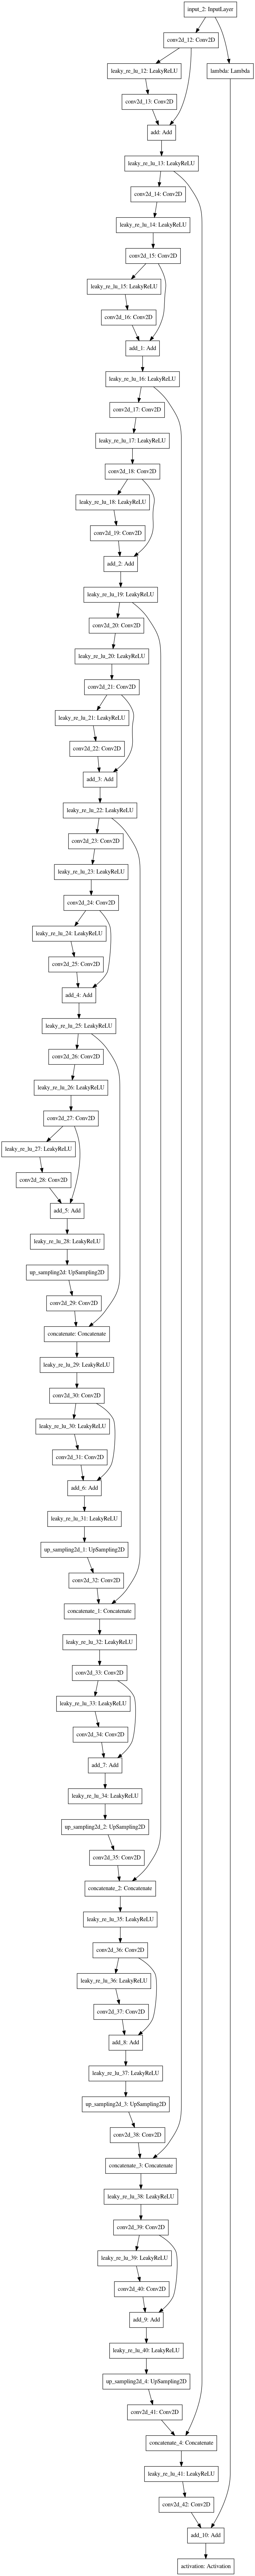

In [12]:
plot_model(generator)

In [24]:
!conda install --yes -c conda-forge pydotplus

Solving environment: done

## Package Plan ##

  environment location: /home/anvilarth/anaconda3/envs/Imin

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         171 KB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    anaconda::ca-certificates-2019.10.16-0 --> conda-forge::ca-certificates-2019.9.11-hecc5488_0
  certifi                                          anaconda --> conda-forge
  openssl                anaconda::op

In [81]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [82]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2] * input_shape[3], tf.float32)
    return result/(num_locations)

In [83]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    @tf.function
    def call(self, inputs, training=None):
        inputs = inputs * 127.5 + tf.constant([3.82, 10.72, 23.56])
        red, green, blue = tf.split(inputs, 3, tf.shape(inputs).shape[0] - 1)
        inputs_bgr = tf.concat([blue, green, red], axis = tf.shape(inputs).shape[0] - 1) 
        outputs = self.vgg(inputs_bgr)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [65]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block4_conv2', 'block5_conv2']
num_style_layers = len(style_layers)
num_content_layers = len(content_layers)

In [66]:
extractor = StyleContentModel(style_layers, content_layers)

In [67]:
cross_entropy = tf.losses.BinaryCrossentropy(from_logits = False)

def generator_loss(y_real, y_gen, generated_output, outputs_real, outputs_fake):
    style_real = outputs_real['style']
    content_real = outputs_real['content']
    
    style_fake = outputs_fake['style']
    content_fake = outputs_fake['content']
    
    style_loss = tf.add_n([tf.reduce_mean(tf.abs(style_real[name]-style_fake[name])) 
                           for name in style_layers])
    style_loss /= num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.abs(content_real[name]-content_fake[name])) 
                             for name in content_layers])
    content_loss / num_content_layers
    
    l1_loss = tf.reduce_mean(tf.abs(y_gen - y_real))
    gan_loss = cross_entropy(tf.ones_like(generated_output, dtype= 'float32'), generated_output) 
    
#     width = tf.cast(image_size - tf.reduce_min(tf.reduce_sum(mask, axis = 1)), tf.int32)
#     height = tf.cast(image_size - tf.reduce_min(tf.reduce_sum(mask, axis = 0)), tf.int32)

#     x = tf.reduce_max(tf.argmin(mask, axis = 1, output_type = tf.int32))
#     y = tf.reduce_max(tf.argmin(mask, axis = 0, output_type = tf.int32))
        
#     mask_loss = tf.reduce_mean(tf.abs(y_real[:, x: x + width, y: y + height, :] - y_gen[:, x: x + width, y: y + height, :]))
    return l1_loss + style_loss + content_loss + 5 * gan_loss # + 2 * mask_loss

In [68]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output, dtype= 'float32') * np.random.uniform(low = 0.9, high = 1), real_output) 
    gen_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return 0.5 * (real_loss + gen_loss)

In [69]:
discr_loss = tf.keras.metrics.Mean(name='dicriminator_loss')
gene_loss = tf.keras.metrics.Mean(name='generator_loss')

In [1]:
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs' + current_time + '/train'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
"""
    Add loger
    Add gated_conv 
"""

'\n    Add loger\n    Add gated_conv \n'

In [70]:
@tf.function()
def train_step(real_image, fake_image, update_d):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(fake_image, training = True)

        real_output = discriminator(real_image, training = True)
        fake_output = discriminator(generated_image, training = True)
        
        outputs_real = extractor(real_image) 
        outputs_fake = extractor(generated_image)

        gen_loss = generator_loss(real_image,  generated_image, fake_output, outputs_real, outputs_fake)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    if update_d:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    if update_d:
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gene_loss(gen_loss)
    discr_loss(disc_loss)

In [71]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr_d, beta_1 = beta1)
generator_optimizer = tf.keras.optimizers.Adam(lr_g, beta_1= beta1)

In [72]:
check = read_labels(all_image_paths[100])
innos = check[:, :, :5]
setok = tf.reshape(innos, (1, image_size, image_size, 5))

In [73]:
def generate_and_save_images(model, test_input, epoch = 33330):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12,8))

    plt.imshow(tf.cast(tf.squeeze(predictions) * 127.5 + 127.5, tf.uint8))
    plt.axis('off')

    plt.savefig('../image_saves3/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [74]:
def train(dataset, epochs):
    update_d = True
    for epoch in range(epochs):
        start = time.time()
        for (in_image, true_image) in dataset:
            train_step(true_image, in_image, update_d)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print ('Generator loss {}, Discriminator loss {} '.format(gene_loss.result(), discr_loss.result()))
        
        generate_and_save_images(generator, setok, epoch)
        
        generator.save('../generator_saves3/generator--{:02d}-{:.4f}.h5'.format(epoch, gene_loss.result()))
        discriminator.save('../discriminator_saves3/discriminator--{:02d}-{:.4f}.h5'.format(epoch, discr_loss.result()))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch)
            tf.summary.scalar('discr_loss', gene_loss.result(), step=epoch)
            
        if discr_loss.result() <= 0.3 * 0.999 **(epoch):
            update_d = False
        else: update_d = True
        
        discr_loss.reset_states()
        gene_loss.reset_states()

In [75]:
# generator.compile(optimizer= tf.keras.optimizers.Adam(), loss = t_loss) 
# generator.fit(ds, epochs = 30, shuffle = True)

In [76]:
## Noise in mask instead 127.5

W0831 16:54:40.199286 139635820848896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0831 16:54:40.230839 139635820848896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0831 16:54:40.250262 139635820848896 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0831 16:54:40.278585 139636651300608 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0831 16:54:40.309705 139636651300608 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0831 16:56:17.833426 139649345795904 deprecation.py:323] From /home/andrewfilatov/miniconda3/envs/gan/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions f

Time for epoch 1 is 188.36591982841492 sec
Generator loss 521.8471069335938, Discriminator loss 0.2347670942544937 


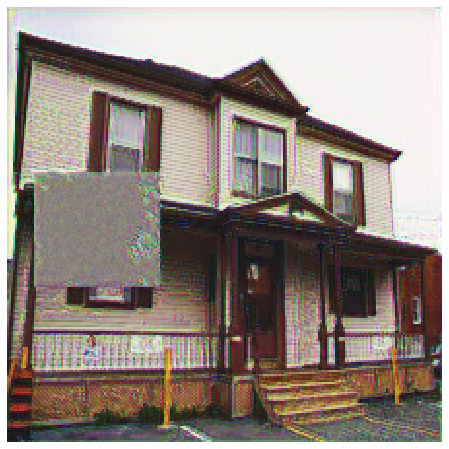

Time for epoch 2 is 163.47535586357117 sec
Generator loss 187.1691131591797, Discriminator loss 0.6548417210578918 


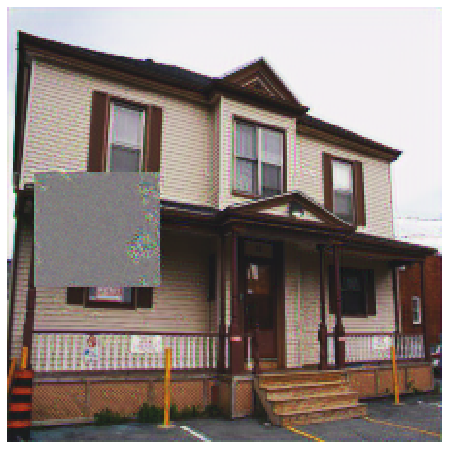

Time for epoch 3 is 164.89966297149658 sec
Generator loss 140.4292449951172, Discriminator loss 0.6271659135818481 


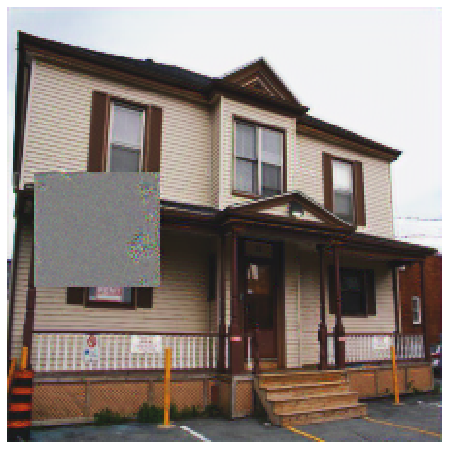

Time for epoch 4 is 163.79236674308777 sec
Generator loss 127.57318878173828, Discriminator loss 0.5558332800865173 


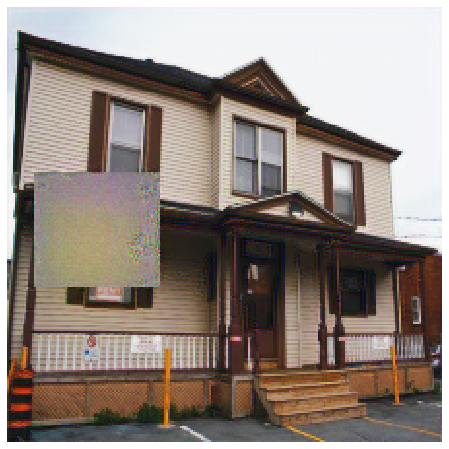

Time for epoch 5 is 164.2093677520752 sec
Generator loss 118.29270935058594, Discriminator loss 0.5703502893447876 


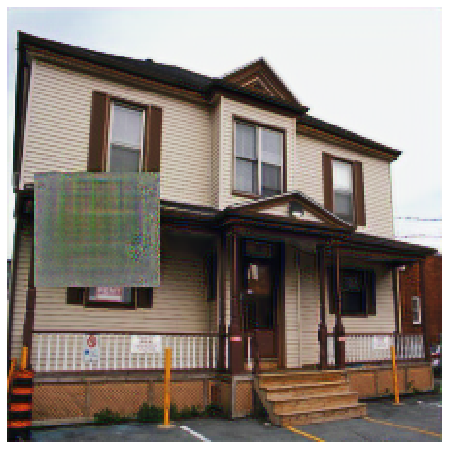

Time for epoch 6 is 162.87919759750366 sec
Generator loss 109.93260192871094, Discriminator loss 0.6089679598808289 


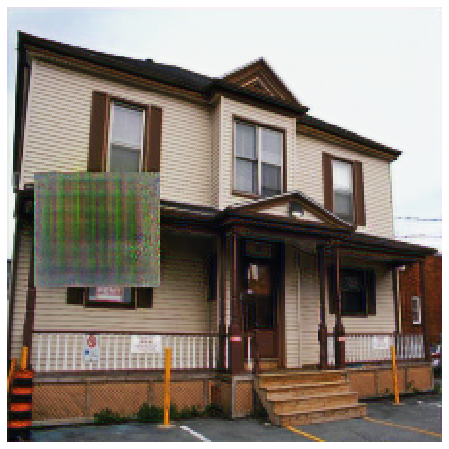

In [ ]:
train(ds, 50)

In [267]:
!wget https://i.ytimg.com/vi/FG0CNT_o5w0/maxresdefault.jpg

--2019-09-03 19:52:25--  https://i.ytimg.com/vi/FG0CNT_o5w0/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 81.5.81.79
Connecting to i.ytimg.com (i.ytimg.com)|81.5.81.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64092 (63K) [image/jpeg]
Saving to: ‘maxresdefault.jpg.1’

maxresdefault.jpg.1 100%[===================>]  62,59K  --.-KB/s    in 0,002s  

2019-09-03 19:52:25 (35,6 MB/s) - ‘maxresdefault.jpg.1’ saved [64092/64092]



In [353]:
check = read_labels(all_image_paths[567])

In [354]:
innos = check[:, :, :5]
comp = check[:, :, 5:]
rebra = check[:,:, 3]
mask = check[:, :, 4]
im_mask = check[:, :, :3]

In [355]:
setok = tf.reshape(innos, (1, 224, 224, 5))
nice = generator.predict(setok)
cool = nice.reshape(224,224, 3)
true_comp = tf.reshape(comp, (1, 224, 224, 3))

# pred = vgg_w(nice * 127.5 + 127.5)
# true = vgg_w(true_comp * 127.5 + 127.5)

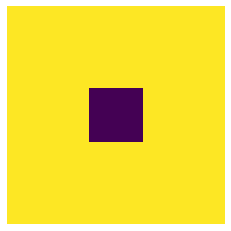

In [356]:
plt.axis('off')
plt.imshow(mask)

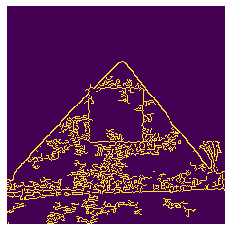

In [357]:
plt.axis('off')
plt.imshow(rebra)

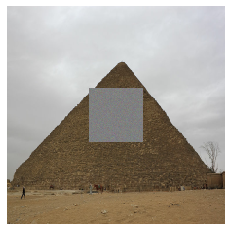

In [358]:
plt.axis('off')
plt.imshow(tf.cast(im_mask * 127.5 + 127.5, tf.uint8))

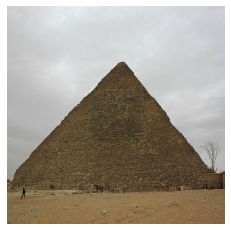

In [359]:
plt.axis('off')
plt.imshow((cool * 127.5 + 127.5).astype(np.uint8))

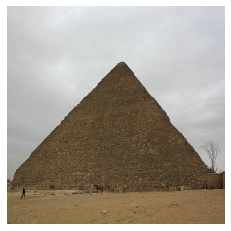

In [360]:
plt.axis('off')
plt.imshow(tf.cast(comp * 127.5 + 127.5, tf.uint8))